# Banana Bot RetinaNet Code
## Samuel Horovatin, 11185403, sch923

Based on: https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb

In [1]:
import tensorflow as tf
import keras_retinanet
from tensorflow import keras

# import retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu
from keras.models import Model

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import glob

# use this to change which GPU to use
gpu = "0"

# set the modified tf session as backend in keras
setup_gpu(gpu)

Using TensorFlow backend.
1 Physical GPUs, 1 Logical GPUs


In [50]:
def direct_regression_modul(pyramid_feature_size=256, regression_feature_size=256, name='direct_regression_submodel'):
    
    options = {
        'kernel_size'        : 3,
        'strides'            : 1,
        'padding'            : 'same',
        'kernel_initializer' : keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
        'bias_initializer'   : 'zeros'
    }
    if keras.backend.image_data_format() == 'channels_first':
        inputs  = keras.layers.Input(shape=(pyramid_feature_size, None, None))
    else:
        inputs  = keras.layers.Input(shape=(None, None, pyramid_feature_size))
    outputs = inputs

    outputs = keras.layers.Conv2D(
            filters=regression_feature_size,
            activation='relu',
            name='direct_reg_conv_1',
            **options
        )(outputs)
    outputs = keras.layers.Conv2D(
                filters=regression_feature_size,
                activation='relu',
                name='direct_reg_conv_2',
                **options
            )(outputs)
    outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    outputs = keras.layers.Dense(
                units=128,
                activation='relu',
                name='direct_reg_dense_1'
            )(outputs)
    outputs = keras.layers.Dense(
                units=64,
                activation='relu',
                name='direct_reg_dense_2'
            )(outputs)
    outputs = keras.layers.Dense(
                units=2,
                activation='softmax',
                name='direct_reg_output'
            )(outputs)

    return keras.models.Model(inputs=inputs, outputs=outputs, name=name)

In [53]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = "G:\\shoro\\OneDrive - Personal\OneDrive\School\\2020-2021\\CMPT 898\\CMPT898_Repo\\Project\\resnet50_coco_best_v2.1.0.h5"

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

layer_name = 'regression'
count_network = [
    ('direct_regression', direct_regression_modul())
]
regression_model = keras_retinanet.models.backbone('resnet50').retinanet(
   num_classes = 1,
   submodels = count_network
)
regression_model.compile(
    loss={
        'direct_regression'    : keras_retinanet.losses.smooth_l1()
    },
    optimizer=keras.optimizers.Adam(lr=1e-5, clipnorm=0.001)
)
regression_model.summary()
# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_10[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________

processing time:  0.5034651756286621


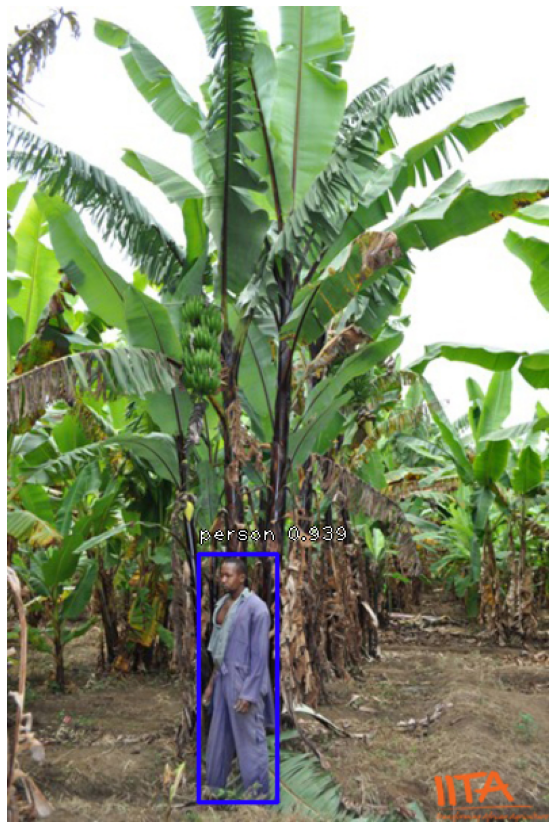

In [9]:

# load image
image = read_image_bgr('test0004.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
with tf.device('/gpu:0'):
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()